In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import intake
from easygems import healpix as egh
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import time


### HEALPix Zoom requested

In [2]:
# Define zoom
zoom = 7


### Load ICON & UM datasets from local disks

In [3]:
GE_path = "/g/data/qx55/germany_node/d3hp003.zarr"
GE_file = f"P1D_mean_z{zoom}_atm.zarr" # Max zoom: 11

UK_path = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/"
UK_file = f"data.healpix.PT1H.z{zoom}.zarr" # Max zoom: 10

ge = xr.open_zarr(os.path.join(GE_path, GE_file))
uk = xr.open_zarr(os.path.join(UK_path, UK_file))


### Load ERA5 dataset from online catalog

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="intake_xarray")

# Load ERA5 monthly average from online catalog
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["online"]
era5 = cat["ERA5"](zoom = zoom).to_dask()


### Print variable list if needed
Uncomment last line to show table

In [5]:
# Create a list to store rows
data = []
ds = uk

# Loop through dataset variables
for var in ds.data_vars:
    name = var
    desc = ds[var].attrs.get('long_name', var).replace('_', ' ').title()
    unit = ds[var].attrs.get('units', '')
    
    # Determine dimensionality
    ndim = ds[var].ndim
    if ndim == 2:
        dim_type = "2D"
    elif ndim == 3:
        dim_type = "3D"
    else:
        dim_type = f"{ndim}D"  # fallback for other dimensions (e.g., 1D, 4D)

    # Append row
    data.append([name, desc, unit, dim_type])

# Create and print the DataFrame
df = pd.DataFrame(data, columns=["Variable Name", "Description", "Unit", "Dimensions"])

# Display DataFrame with left-avg headers and content
# display(df.style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))


### Checkout time range and frequency

In [6]:
def describe_time(ds, name):
    time = ds.time
    print(f"\n{name}:")
    print(f"  First time step : {str(time.values[0])}")
    print(f"  Last time step  : {str(time.values[-1])}")
    print(f"  Number of steps : {len(time)}")

    # Infer frequency
    if len(time) > 1:
        inferred_freq = pd.infer_freq(time.to_index())
        print(f"  Inferred freq   : {inferred_freq}")
    else:
        print("  Not enough data to infer frequency.")

# Assuming these datasets are already loaded
describe_time(uk, "UK dataset")
describe_time(ge, "Germany dataset")
describe_time(era5, "ERA5 dataset")



UK dataset:
  First time step : 2020-01-20T00:00:00.000000000
  Last time step  : 2021-04-01T00:00:00.000000000
  Number of steps : 10489
  Inferred freq   : h

Germany dataset:
  First time step : 2020-01-02T00:00:00.000000000
  Last time step  : 2021-03-01T00:00:00.000000000
  Number of steps : 425
  Inferred freq   : D

ERA5 dataset:
  First time step : 1940-01-01T00:00:00.000000000
  Last time step  : 2023-12-01T00:00:00.000000000
  Number of steps : 1008
  Inferred freq   : MS


### Define commmon time range

In [7]:
# Extract time variables
uk_time = uk.time
ge_time = ge.time
era5_time = era5.time

# Compute latest common start and earliest common end time
start_time = max(uk_time.values[0], ge_time.values[0], era5_time.values[0])
end_time = min(uk_time.values[-1], ge_time.values[-1], era5_time.values[-1])

print(f"Common time range: {start_time} to {end_time}")

# Calculate number of days (safe for numpy datetime64)
num_days = (end_time - start_time) / np.timedelta64(1, 'D')
num_days = int(num_days)  # optional: convert to int if you want a clean scalar

print(f"Number of days: {num_days}")


Common time range: 2020-01-20T00:00:00.000000000 to 2021-03-01T00:00:00.000000000
Number of days: 406


### Crop time range
According to group's choice

In [8]:
# Crop time range as defined by the group
start_time = "2020-03-01"
end_time = "2021-02-28"

uk = uk.sel(time=slice(start_time, end_time))
ge = ge.sel(time=slice(start_time, end_time))
era5 = era5.sel(time=slice(start_time, end_time))


### Rename variable for simplicity and later use

In [9]:
# Rename variables consistently across datasets
uk = uk.rename({'pr': 'Rain', 'uas': 'U10', 'vas': 'V10'})
ge = ge.rename({'pr': 'Rain', 'uas': 'U10', 'vas': 'V10'})
era5 = era5.rename({'tp': 'Rain', '10u': 'U10', '10v': 'V10'})


## Choose variable to work with

In [27]:
# Variable to be averaged
var = 'Rain'


### Average datasets over time

In [28]:
# GE average
start = time.time()
ge_avg = ge[var].mean(dim='time').load()
end = time.time()
print(f"GE average loaded in {end - start:.2f} seconds")


GE average loaded in 0.63 seconds


In [29]:
# UK average
start = time.time()
uk_avg = uk[var].mean(dim='time').load()
end = time.time()
print(f"UK average loaded in {end - start:.2f} seconds")


UK average loaded in 3.16 seconds


In [30]:
# ERA5 average
start = time.time()
era5_avg = era5[var].mean(dim='time').load()
end = time.time()
print(f"ERA5 average loaded in {end - start:.2f} seconds")


ERA5 average loaded in 12.46 seconds


### Correct for Rain units: all in mm/day

In [31]:
if var == 'Rain':
    # Convert GE and UK from kg/m²/s to mm/day (×86400)
    ge_avg *= 86400
    uk_avg *= 86400

    # Convert ERA5 from m to mm (×1000)
    era5_avg *= 1000

## Plot mapped data and anomalies (vs. ERA5)

### Choose which kind of Anomaly you want:
- Abs : Absolute anomalies
- Rel : Relative anomalies

In [35]:
# Compute anomalies

# Choose anomaly to compute
anom = 'rel'

if anom == 'abs':
    ge_anom = ge_avg - era5_avg
    uk_anom = uk_avg - era5_avg
elif anom == 'rel':
    ge_anom = (ge_avg - era5_avg) / era5_avg * 100
    uk_anom = (uk_avg - era5_avg) / era5_avg * 100
else:
    raise ValueError(f"Unsupported anomaly type: {anom} (use 'abs' or 'rel')")


### Define colorbar range and colormaps according to variable

In [36]:
# Define colorbar limits and colormaps based on variable and anomaly type
if var == 'Rain':
    vmin_main, vmax_main = 0, 14
    cmap_main = "YlGnBu"
    cmap_anom = "BrBG"
    unit_main = 'mm/day'

    if anom == 'abs':
        vmin_anom, vmax_anom = -6, 6 ; unit_anom = 'mm/day'
    elif anom == 'rel':
        vmin_anom, vmax_anom = -100, 100 ; unit_anom = '%'
    else:
        raise ValueError(f"Unsupported anomaly type: {anom} (use 'abs' or 'rel')")

elif var in ['U10', 'V10']:
    vmin_main, vmax_main = -15, 15
    cmap_main = "Spectral_r"
    cmap_anom = "RdBu_r"
    unit_main = 'm/s'

    if anom == 'abs':
        vmin_anom, vmax_anom = -6, 6 ; unit_anom = 'm/s'
    elif anom == 'rel':
        vmin_anom, vmax_anom = -100, 100 ; unit_anom = '%'
    else:
        raise ValueError(f"Unsupported anomaly type: {anom} (use 'abs' or 'rel')")

else:
    raise ValueError(f"Unsupported variable: {var} (supported: 'Rain', 'U10', 'V10')")


### Plotting figure using GridSpec

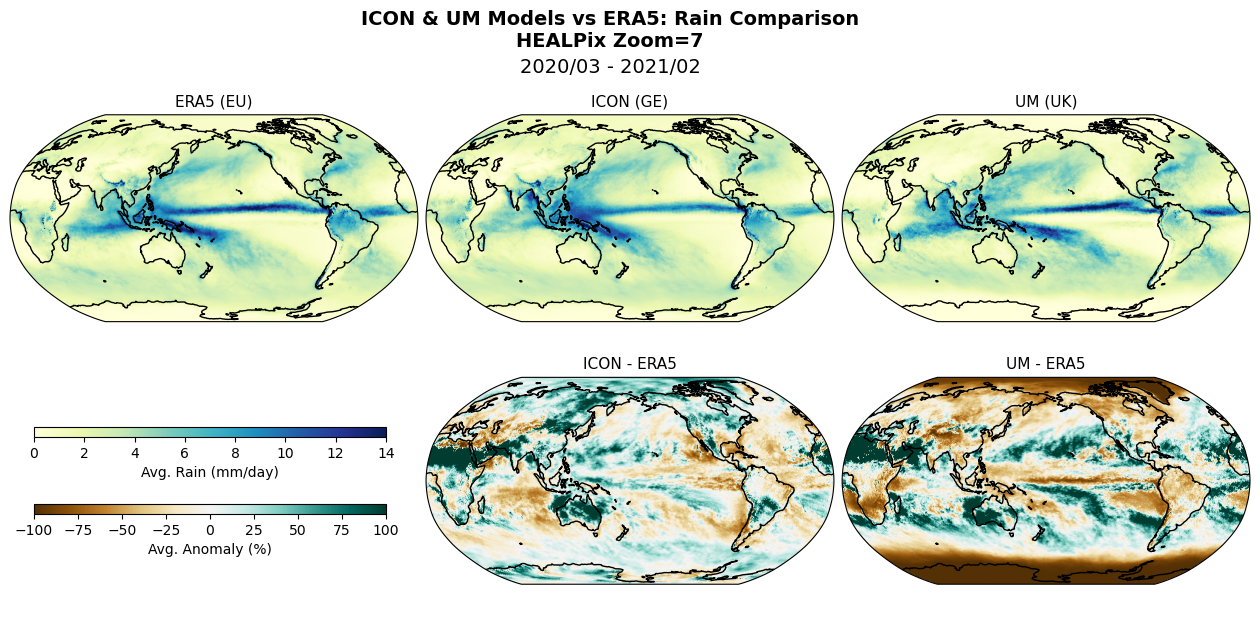

In [37]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# Projection
projection = ccrs.Robinson(central_longitude=180)

# Create figure and grid
fig = plt.figure(figsize=(16, 7))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1], hspace=-0.05, wspace=0.02)

# Add figure-wide title
fig.suptitle(f'ICON & UM Models vs ERA5: {var} Comparison\nHEALPix Zoom={zoom}', fontsize=14, fontweight='bold', y=0.98)
start_str = pd.to_datetime(start_time).strftime('%Y/%m')
end_str = pd.to_datetime(end_time).strftime('%Y/%m')
fig.text(0.5, 0.89, f'{start_str} - {end_str}', ha='center', fontsize=14)

# Top row: mean plots
datasets = [("ERA5 (EU)", era5_avg),
            ("ICON (GE)", ge_avg),
            ("UM (UK)", uk_avg)]

for i, (title, data) in enumerate(datasets):
    ax = fig.add_subplot(gs[0, i], projection=projection)
    ax.set_global()
    im_main = egh.healpix_show(data, ax=ax, cmap=cmap_main, vmin=vmin_main, vmax=vmax_main)
    ax.coastlines()
    ax.set_title(title, fontsize=11)

# Bottom row: anomalies (columns 1 and 2 only)
anomalies = [("ICON - ERA5", ge_anom),
             ("UM - ERA5", uk_anom)]

for i, (title, data) in enumerate(anomalies):
    ax = fig.add_subplot(gs[1, i+1], projection=projection)
    ax.set_global()
    im_anom = egh.healpix_show(data, ax=ax, cmap=cmap_anom, vmin=vmin_anom, vmax=vmax_anom)
    ax.coastlines()
    ax.set_title(title, fontsize=11)

# Colorbars in (1, 0) slot
# Reserve space visually using a dummy (blank) axis
ax_cb = fig.add_subplot(gs[1, 0])
ax_cb.axis('off')

# Define manual axes for colorbars
cb_ax1 = fig.add_axes([0.14, 0.37, 0.22, 0.015])  # top colorbar
cb_ax2 = fig.add_axes([0.14, 0.26, 0.22, 0.015])  # bottom colorbar

cb1 = fig.colorbar(im_main, cax=cb_ax1, orientation='horizontal')
cb1.set_label(f"Avg. {var} ({unit_main})")

cb2 = fig.colorbar(im_anom, cax=cb_ax2, orientation='horizontal')
cb2.set_label(f"Avg. Anomaly ({unit_anom})")

plt.show()


In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# Convert time to pandas index for frequency detection
uk_freq = pd.infer_freq(uk.time.to_index())
ge_freq = pd.infer_freq(ge.time.to_index())
era5_freq = pd.infer_freq(era5.time.to_index())

# Get time step in seconds from differences
def get_timestep_seconds(time):
    dt = (time[1] - time[0]).astype('timedelta64[s]').item().total_seconds()
    return dt

uk_step_sec = get_timestep_seconds(uk.time.values)
print(f'UK: {uk_step_sec}')
ge_step_sec = get_timestep_seconds(ge.time.values)
print(f'GE: {ge_step_sec}')


In [ ]:
import matplotlib.pyplot as plt

# Define common colorbar range
vmin = 0
vmax = 15

# Plot ERA5
im = egh.healpix_show(era5_avg, cmap="YlGnBu", vmin=vmin, vmax=vmax, dpi=100)
plt.title('ERA5 (EU)')
plt.colorbar(im, orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()

# Plot GE
im = egh.healpix_show(ge_avg, cmap="YlGnBu", vmin=vmin, vmax=vmax, dpi=100)
plt.title('ICON (GE)')
plt.colorbar(im, orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()

# Plot UK
im = egh.healpix_show(uk_avg, cmap="YlGnBu", vmin=vmin, vmax=vmax, dpi=100)
plt.title('UM (UK)')
plt.colorbar(im, orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Compute anomalies
ge_anom = ge_avg - era5_avg
uk_anom = uk_avg - era5_avg

# Define consistent color scale for anomalies
vmin = -5
step = 1
vmax = - vmin
cmap = "BrBG"  # or "BrBG" if BrGn isn't available

# Plot GE - ERA5 anomaly
im = egh.healpix_show(ge_anom, cmap=cmap, vmin=vmin, vmax=vmax, dpi=100)
plt.title('ICON (GE) - ERA5 Anomaly')
plt.colorbar(im, orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()

# Plot UK - ERA5 anomaly
im = egh.healpix_show(uk_anom, cmap=cmap, vmin=vmin, vmax=vmax, dpi=100)
plt.title('UM (UK) - ERA5 Anomaly')
plt.colorbar(im, orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()


In [ ]:
# Define the list of variables to keep
keep_vars = ['Rain', 'U10', 'V10']

# Clean dataset : drop all other variables
def keep_only(ds, vars_to_keep):
    return ds.drop_vars([v for v in ds.data_vars if v not in vars_to_keep])

# Apply to each dataset
uk = keep_only(uk, keep_vars)
ge = keep_only(ge, keep_vars)
era5 = keep_only(era5, keep_vars)